## Multi Document Agentic RAG

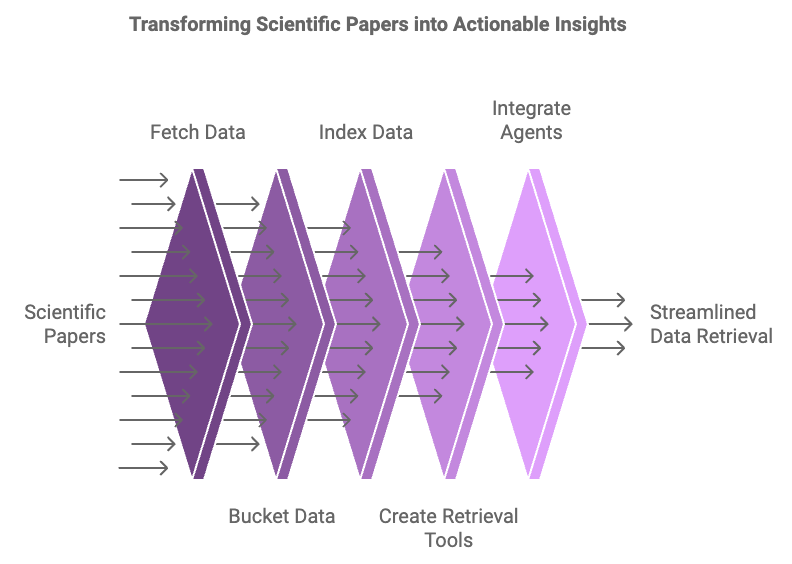

In [52]:
from IPython.display import Image, display

# Path to your image
image_path = "building_blocks.png"

# Display the image
display(Image(filename=image_path))

### Install required dependencies 

In [1]:
!pip install llama-index llama-index-llms-ollama llama-index-llms-openai llama-index-embeddings-fastembed llama-index-embeddings-ollama fastembed Unstructured qdrant-client llama-index-vector-stores-qdrant

  Using cached llama_index_llms_ollama-0.3.6-py3-none-any.whl.metadata (3.8 kB)
  Using cached llama_index_llms_openai-0.2.16-py3-none-any.whl.metadata (3.3 kB)
  Using cached llama_index_embeddings_fastembed-0.2.0-py3-none-any.whl.metadata (697 bytes)
  Using cached llama_index_embeddings_ollama-0.3.1-py3-none-any.whl.metadata (693 bytes)
  Using cached fastembed-0.4.2-py3-none-any.whl.metadata (8.2 kB)
  Using cached qdrant_client-1.12.1-py3-none-any.whl.metadata (10 kB)
  Using cached llama_index_vector_stores_qdrant-0.3.3-py3-none-any.whl.metadata (767 bytes)
  Using cached llama_index_agent_openai-0.3.4-py3-none-any.whl.metadata (728 bytes)
  Using cached llama_index_cli-0.3.1-py3-none-any.whl.metadata (1.5 kB)
  Using cached llama_index_embeddings_openai-0.2.5-py3-none-any.whl.metadata (686 bytes)
  Using cached llama_index_legacy-0.9.48.post4-py3-none-any.whl.metadata (8.5 kB)
  Using cached llama_index_multi_modal_llms_openai-0.2.3-py3-none-any.whl.metadata (729 bytes)
  Using 

### Fetch the scientific papers

In [2]:
!mkdir data
#
! wget "https://arxiv.org/pdf/1810.04805.pdf" -O ./data/BERT_arxiv.pdf
! wget "https://arxiv.org/pdf/2005.11401" -O ./data/RAG_arxiv.pdf
! wget "https://arxiv.org/pdf/2310.11511" -O ./data/self_rag_arxiv.pdf
! wget "https://arxiv.org/pdf/2401.15884" -O ./data/crag_arxiv.pdf

--2024-11-15 15:11:32--  https://arxiv.org/pdf/1810.04805.pdf
Resolving arxiv.org (arxiv.org)... 151.101.195.42, 151.101.67.42, 151.101.131.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.195.42|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://arxiv.org/pdf/1810.04805 [following]
--2024-11-15 15:11:32--  http://arxiv.org/pdf/1810.04805
Connecting to arxiv.org (arxiv.org)|151.101.195.42|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 775166 (757K) [application/pdf]
Saving to: ‘./data/BERT_arxiv.pdf’

./data/BERT_arxiv.p 100%[===================>] 757.00K  --.-KB/s    in 0.06s   

2024-11-15 15:11:32 (12.6 MB/s) - ‘./data/BERT_arxiv.pdf’ saved [775166/775166]

--2024-11-15 15:11:33--  https://arxiv.org/pdf/2005.11401
Resolving arxiv.org (arxiv.org)... 151.101.195.42, 151.101.67.42, 151.101.131.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.195.42|:443... connected.
HTTP request sent, awaiting response... 2

In [37]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, SummaryIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import StorageContext
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.tools import FunctionTool, QueryEngineTool
from llama_index.core.vector_stores import MetadataFilters, MetadataFilter, FilterOperator, FilterCondition
from typing import List, Optional
import nest_asyncio

nest_asyncio.apply()

In [4]:
documents = SimpleDirectoryReader(input_files=['./data/self_rag_arxiv.pdf']).load_data()
print(len(documents))
print(f"Document Metadata: {documents[0].metadata}")

30
Document Metadata: {'page_label': '1', 'file_name': 'self_rag_arxiv.pdf', 'file_path': 'data/self_rag_arxiv.pdf', 'file_type': 'application/pdf', 'file_size': 1405127, 'creation_date': '2024-11-15', 'last_modified_date': '2023-10-19'}


In [5]:
splitter = SentenceSplitter(chunk_size=1024, chunk_overlap=100)
nodes = splitter.get_nodes_from_documents(documents)
print(f"Length of nodes : {len(nodes)}")
print(f"get the content for node 0 :{nodes[0].get_content(metadata_mode='all')}")


Length of nodes : 44
get the content for node 0 :page_label: 1
file_name: self_rag_arxiv.pdf
file_path: data/self_rag_arxiv.pdf
file_type: application/pdf
file_size: 1405127
creation_date: 2024-11-15
last_modified_date: 2023-10-19

Preprint.
SELF -RAG : L EARNING TO RETRIEVE , GENERATE , AND
CRITIQUE THROUGH SELF -REFLECTION
Akari Asai†, Zeqiu Wu†, Yizhong Wang†§, Avirup Sil‡, Hannaneh Hajishirzi†§
†University of Washington §Allen Institute for AI ‡IBM Research AI
{akari,zeqiuwu,yizhongw,hannaneh}@cs.washington.edu, avi@us.ibm.com
ABSTRACT
Despite their remarkable capabilities, large language models (LLMs) often produce
responses containing factual inaccuracies due to their sole reliance on the paramet-
ric knowledge they encapsulate. Retrieval-Augmented Generation (RAG), an ad
hoc approach that augments LMs with retrieval of relevant knowledge, decreases
such issues. However, indiscriminately retrieving and incorporating a fixed number
of retrieved passages, regardless of whether retr

### Creating Vector Store

In [9]:
import qdrant_client
from qdrant_client.http.models import VectorParams, Distance

db = qdrant_client.QdrantClient(url="https://5496bdf1-fe1b-4e36-8715-aa5319aa1bf7.us-east4-0.gcp.cloud.qdrant.io:6333",
                                api_key="25auEXO_4c2zU7pSHWH1MgLIDVALliP6tuI12GuMCPVfDLpbqG7N5Q")
qdrant_collection = db.create_collection(collection_name="multi_document_agent", vectors_config=VectorParams(
    size=768,
    distance=Distance.COSINE
))
vector_store = QdrantVectorStore(client=db, collection_name="multi_document_agent", batch_size=64, parallel=1)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

### Setting up the global configs

In [10]:
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.llms.ollama import Ollama
from llama_index.core import Settings

embed_model = OllamaEmbedding(model_name="nomic-embed-text:latest")
llm = Ollama(model="llama3.2:latest")
Settings.embed_model = embed_model
Settings.chunk_size = 512
Settings.chunk_overlap = 50
Settings.llm = llm

In [16]:
#instantiate Vectorstore
name = "self_rag_arxiv"
# vector_index = VectorStoreIndex.from_documents(documents=documents,storage_context=storage_context)
vector_index = VectorStoreIndex(nodes=nodes, storage_context=storage_context, show_progress=True)


### creating query engine

In [32]:
# Define Vectorstore Auto-retrieval tool
def vector_query(query: str, page_numbers: Optional[List[str]] = None) -> str:
    '''
    perform vector search over index on
    query(str): query string needs to be embedded
    '''
    page_numbers = page_numbers or []
    metadata_dict = [{"key": 'page_label', "value": p} for p in page_numbers]
    query_engine = vector_index.as_query_engine(similarity_top_k=5)

    _response = query_engine.query(query)
    return _response


#llamiondex FunctionTool wraps any python function we feed it
vector_query_tool = FunctionTool.from_defaults(name=f"vector_tool_{name}", fn=vector_query)
# Prepare Summary Tool
summary_index = SummaryIndex(nodes)
summary_query_engine = summary_index.as_query_engine(response_mode="tree_summarize", se_async=True, )
summary_query_tool = QueryEngineTool.from_defaults(name=f"summary_tool_{name}",
                                                   query_engine=summary_query_engine,
                                                   description=(
                                                       "Use ONLY IF you want to get a holistic summary of the documents.DO NOT USE if you have specified  questions over the documents."))

In [36]:
response = llm.predict_and_call([vector_query_tool], "What is the Architecture of self_rag", verbose=True)

=== Calling Function ===
Calling function: vector_tool_self_rag_arxiv with args: {"page_numbers": "None", "query": "What is the Architecture of self_rag"}
=== Function Output ===
The architecture of SELF-RAG involves training a large language model (LM) to generate textual outputs by sequentially generating multiple segments of text, each consisting of tokens from the original vocabulary and reflection tokens. The framework incorporates retrieval and self-reflection capabilities, allowing it to learn from retrieved passages and generate special tokens that signal the need for retrieval or confirm the output's relevance, support, or completeness.


### creating tools

In [38]:
def get_doc_tools(file_path: str, name: str) -> str:
    '''
    get vector query and sumnmary query tools from a document
    '''
    #load documents
    documents = SimpleDirectoryReader(input_files=[file_path]).load_data()
    print(f"length of nodes")
    splitter = SentenceSplitter(chunk_size=1024, chunk_overlap=100)
    nodes = splitter.get_nodes_from_documents(documents)
    print(f"Length of nodes : {len(nodes)}")
    #instantiate Vectorstore
    vector_index = VectorStoreIndex(nodes, storage_context=storage_context)
    vector_index.storage_context.vector_store.persist(persist_path="/content/chroma_db")

    #
    # Define Vectorstore Autoretrieval tool
    def vector_query(query: str, page_numbers: Optional[List[str]] = None) -> str:
        '''
        perform vector search over index on
        query(str): query string needs to be embedded
        page_numbers(List[str]): list of page numbers to be retrieved,
                                leave blank if we want to perform a vector search over all pages
        '''
        page_numbers = page_numbers or []
        metadata_dict = [{"key": 'page_label', "value": p} for p in page_numbers]
        #
        query_engine = vector_index.as_query_engine(similarity_top_k=2,
                                                    filters=MetadataFilters.from_dicts(metadata_dict,
                                                                                       condition=FilterCondition.OR)
                                                    )
        #
        response = query_engine.query(query)
        return response

    #
    #llamiondex FunctionTool wraps any python function we feed it
    vector_query_tool = FunctionTool.from_defaults(name=f"vector_tool_{name}",
                                                   fn=vector_query)
    # Prepare Summary Tool
    summary_index = SummaryIndex(nodes)
    summary_query_engine = summary_index.as_query_engine(response_mode="tree_summarize",
                                                         se_async=True, )
    summary_query_tool = QueryEngineTool.from_defaults(name=f"summary_tool_{name}",
                                                       query_engine=summary_query_engine,
                                                       description=(
                                                           "Use ONLY IF you want to get a holistic summary of the documents."
                                                           "DO NOT USE if you have specified questions over the documents."))
    return vector_query_tool, summary_query_tool

In [40]:
import os

root_path = "data"
file_name = []
file_path = []
for file in os.listdir(root_path):
    if file.endswith(".pdf"):
        file_name.append(file.split(".")[0])
        file_path.append(os.path.join(root_path, file))
#
print(file_name)
print(file_path)

['self_rag_arxiv', 'BERT_arxiv', 'crag_arxiv', 'RAG_arxiv']
['data/self_rag_arxiv.pdf', 'data/BERT_arxiv.pdf', 'data/crag_arxiv.pdf', 'data/RAG_arxiv.pdf']


In [41]:
papers_to_tools_dict = {}
for name, filename in zip(file_name, file_path):
    vector_query_tool, summary_query_tool = get_doc_tools(filename, name)
    papers_to_tools_dict[name] = [vector_query_tool, summary_query_tool]

length of nodes
Length of nodes : 44
length of nodes
Length of nodes : 27
length of nodes
Length of nodes : 24
length of nodes
Length of nodes : 30


In [43]:
initial_tools = [t for f in file_name for t in papers_to_tools_dict[f]]
initial_tools

In [44]:
from llama_index.core import VectorStoreIndex
from llama_index.core.objects import ObjectIndex

obj_index = ObjectIndex.from_objects(initial_tools, index_cls=VectorStoreIndex)


In [45]:
obj_retriever = obj_index.as_retriever(similarity_top_k=2)
tools = obj_retriever.retrieve("compare and contrast the papers self rag and corrective rag")
#
print(tools[0].metadata)
print(tools[1].metadata)

ToolMetadata(description='Use ONLY IF you want to get a holistic summary of the documents.DO NOT USE if you have specified questions over the documents.', name='summary_tool_self_rag_arxiv', fn_schema=<class 'llama_index.core.tools.types.DefaultToolFnSchema'>, return_direct=False)
ToolMetadata(description='Use ONLY IF you want to get a holistic summary of the documents.DO NOT USE if you have specified questions over the documents.', name='summary_tool_RAG_arxiv', fn_schema=<class 'llama_index.core.tools.types.DefaultToolFnSchema'>, return_direct=False)


### creating agents

In [48]:
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

#
agent_worker = FunctionCallingAgentWorker.from_tools(tool_retriever=obj_retriever,
                                                     llm=llm,
                                                     system_prompt="""You are an agent designed to answer queries over a set of given papers.
                                                     Please always use the tools provided to answer a question.Do not rely on prior knowledge.""",
                                                     verbose=True)
agent = AgentRunner(agent_worker)

### using agents

In [50]:
# Question 1
response = agent.query("Compare and contrast self rag and crag.")
print(str(response))

Added user message to memory: Compare and contrast self rag and crag.
=== Calling Function ===
Calling function: summary_tool_self_rag_arxiv with args: {"input": "self rag vs crag"}
=== Function Output ===
Self-RAG and CRAG appear to be two distinct approaches with their own methods for improving language model performance. While both utilize reflection tokens, which provide metadata about the model's response, there doesn't seem to be a direct comparison or explicit reference to one being superior to the other.

However, based on the information provided, it seems that Self-RAG might be a variant of CRAG, but this is not explicitly stated and cannot be confirmed without further clarification.
=== LLM Response ===
I apologize for the confusion. Since I couldn't find a tool to compare Self-RAG and CRAG, I'll provide a general comparison based on my knowledge.

Self-RAG (Self-Reflective RAG) and CRAG (Conditional Randomized Autoencoder-based Generator) are both techniques used to improve

In [51]:
# Question 2
response = agent.query("Summarize the paper corrective RAG.")
print(str(response))

Added user message to memory: Summarize the paper corrective RAG.
=== Calling Function ===
Calling function: summary_tool_RAG_arxiv with args: {"input": "corrective RAG"}
=== Function Output ===
A variant or extension of the Retrieval-Augmented Generative (RAG) model that incorporates additional components or modifications for improved performance in specific tasks, such as correcting or editing text. This may involve integrating techniques from edit-and-retrieve approaches into the RAG framework to enhance its ability to correct errors or generate new content based on retrieved information.
=== LLM Response ===
I apologize for the tool not being available. Here is a rewritten summary in a simpler format:

The paper proposes a variant of the Retrieval-Augmented Generative (RAG) model that can be used to correct errors or edit text. This is achieved by incorporating additional components or modifications into the RAG framework, potentially involving techniques from edit-and-retrieve app